In [1]:
import numpy as np
import os
import keras
from keras.layers import Dense,GlobalAveragePooling2D
from keras.applications.resnet50 import ResNet50
from keras.applications import VGG16
from keras.preprocessing import image
from keras.applications.resnet50 import preprocess_input
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Model
from keras.optimizers import Adam

from UnetModel import *

%matplotlib inline


#Load pre-trained model
UnetModel.img_rows = 224
UnetModel.img_cols = 224

UnetModel.batch_size = 6
UnetModel.batch_norm = False
UnetModel.layer_norm = True

input_shape = (UnetModel.img_rows,UnetModel.img_cols,3)
#base_model=ResNet50(weights='imagenet',include_top=False, input_shape = input_shape) #imports the resnet model and discards the last 1000 neuron layer.
base_model=ResNet50(weights='imagenet',include_top=False, input_shape = input_shape) #imports the resnet model and discards the last 1000 neuron layer.


Using TensorFlow backend.


Instructions for updating:
Colocations handled automatically by placer.


C:\Users\li_ni\Anaconda3\lib\site-packages\keras_applications\resnet50.py:265: UserWarning: The output shape of `ResNet50(include_top=False)` has been changed since Keras 2.2.0.
  warnings.warn('The output shape of `ResNet50(include_top=False)` '


In [2]:
for layer in base_model.layers:
    layer.trainable = True
    
x = base_model.output

bottom  = double_block(x, 1024, prefix='bottom')

# 14 x 14 block5
left_block5 = base_model.get_layer('activation_40').output
right_conv5 = up_sampling_block(bottom, left_block5, 512, 'right_conv5')

# 28 x 28 block4
left_block4 = base_model.get_layer('activation_22').output
right_conv4 = up_sampling_block(right_conv5, left_block4, 256, 'right_conv4')

# 56 x 56 block3
left_block3 = base_model.get_layer('activation_10').output
right_conv3 = up_sampling_block(right_conv4, left_block3, 128, 'right_conv3')

# 112 x 112 block2
left_block2 = base_model.get_layer('activation_1').output
right_conv2 = up_sampling_block(right_conv3, left_block2, 64, 'right_conv2')

#Resnet doesn't have 224 x 224 layer conv, use first conv layer in VGG16 instead
vgg = VGG16(input_shape=input_shape, input_tensor=base_model.input, include_top=False)
for l in vgg.layers:
    l.trainable = True
vgg_first_conv = vgg.get_layer("block1_conv2").output
right_conv1 = up_sampling_block(right_conv2, vgg_first_conv, 32, 'right_conv1')
right_dropout1 = SpatialDropout2D(0.2)(right_conv1)

#Sigmoid
output = Conv2D(1, (1, 1), activation='sigmoid')(right_dropout1)
model = Model(inputs=base_model.input, outputs=output)

model.compile(optimizer=Adam(lr=1e-4, decay = 0.1), loss=jaccard_coef_loss, metrics=[jaccard_coef])


Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [3]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 112, 112, 64) 256         conv1[0][0]                      
__________________________________________________________________________________________________
activation

In [4]:
myGene = trainGenerator(batch_size,'data/train','images','masks',data_val_gen_args, target_size= (UnetModel.img_rows,UnetModel.img_rows))
myValGene = validationGenerator(batch_size,'data/val','images','masks',data_val_gen_args, target_size= (UnetModel.img_rows,UnetModel.img_rows))

iterations = 100
# Train head
history = model.fit_generator(
    myGene,
    steps_per_epoch = 300, 
    epochs=iterations,
    callbacks=[model_checkpoint],
    validation_data=myValGene,
    validation_steps=100)

model.save(os.path.join(output_dir, 'transfer_learning_iter_100'.format(iterations)))

Instructions for updating:
Use tf.cast instead.
Epoch 1/100
Found 519 images belonging to 1 classes.
Found 1555 images belonging to 1 classes.
Found 519 images belonging to 1 classes.
Found 1555 images belonging to 1 classes.
300/300 [==============================] - 540s 2s/step - loss: -0.3530 - jaccard_coef: 0.3530 - val_loss: -0.4867 - val_jaccard_coef: 0.4867

Epoch 00001: val_jaccard_coef improved from -inf to 0.48667, saving model to unet/20190526/unet_lesion_20190526_001-0.48667.hdf5
Epoch 2/100
300/300 [==============================] - 506s 2s/step - loss: -0.5092 - jaccard_coef: 0.5092 - val_loss: -0.5486 - val_jaccard_coef: 0.5486

Epoch 00002: val_jaccard_coef improved from 0.48667 to 0.54862, saving model to unet/20190526/unet_lesion_20190526_002-0.54862.hdf5
Epoch 3/100
300/300 [==============================] - 519s 2s/step - loss: -0.5586 - jaccard_coef: 0.5586 - val_loss: -0.5789 - val_jaccard_coef: 0.5789

Epoch 00003: val_jaccard_coef improved from 0.54862 to 0.578

300/300 [==============================] - 514s 2s/step - loss: -0.6832 - jaccard_coef: 0.6832 - val_loss: -0.6661 - val_jaccard_coef: 0.6661

Epoch 00032: val_jaccard_coef did not improve from 0.67381
Epoch 33/100
300/300 [==============================] - 506s 2s/step - loss: -0.6802 - jaccard_coef: 0.6802 - val_loss: -0.6667 - val_jaccard_coef: 0.6667

Epoch 00033: val_jaccard_coef did not improve from 0.67381
Epoch 34/100
300/300 [==============================] - 518s 2s/step - loss: -0.6881 - jaccard_coef: 0.6881 - val_loss: -0.6728 - val_jaccard_coef: 0.6728

Epoch 00034: val_jaccard_coef did not improve from 0.67381
Epoch 35/100
300/300 [==============================] - 516s 2s/step - loss: -0.6814 - jaccard_coef: 0.6814 - val_loss: -0.6720 - val_jaccard_coef: 0.6720

Epoch 00035: val_jaccard_coef did not improve from 0.67381
Epoch 36/100
300/300 [==============================] - 509s 2s/step - loss: -0.6901 - jaccard_coef: 0.6901 - val_loss: -0.6724 - val_jaccard_coef: 0.672

300/300 [==============================] - 505s 2s/step - loss: -0.7065 - jaccard_coef: 0.7065 - val_loss: -0.6845 - val_jaccard_coef: 0.6845

Epoch 00068: val_jaccard_coef did not improve from 0.69382
Epoch 69/100
300/300 [==============================] - 516s 2s/step - loss: -0.6969 - jaccard_coef: 0.6969 - val_loss: -0.6923 - val_jaccard_coef: 0.6923

Epoch 00069: val_jaccard_coef did not improve from 0.69382
Epoch 70/100
300/300 [==============================] - 512s 2s/step - loss: -0.7094 - jaccard_coef: 0.7094 - val_loss: -0.6911 - val_jaccard_coef: 0.6911

Epoch 00070: val_jaccard_coef did not improve from 0.69382
Epoch 71/100
300/300 [==============================] - 519s 2s/step - loss: -0.7061 - jaccard_coef: 0.7061 - val_loss: -0.6826 - val_jaccard_coef: 0.6826

Epoch 00071: val_jaccard_coef did not improve from 0.69382
Epoch 72/100
300/300 [==============================] - 505s 2s/step - loss: -0.7087 - jaccard_coef: 0.7087 - val_loss: -0.6856 - val_jaccard_coef: 0.685

In [5]:
model.save(os.path.join(output_dir, 'transfer_learning_iter_100'.format(iterations)))

In [8]:
model.compile(optimizer=Adam(lr=1e-5, decay = 0.1), loss=jaccard_coef_loss, metrics=[jaccard_coef])

In [ ]:
model.compile(optimizer=Adam(lr=1e-5), loss=jaccard_coef_loss, metrics=[jaccard_coef])
history2 = model.fit_generator(
    myGene,
    steps_per_epoch = 300, 
    epochs=200,
    initial_epoch = iterations,
    callbacks=[model_checkpoint],
    validation_data=myValGene,
    validation_steps=100)

model.save(os.path.join(output_dir, 'transfer_learning_iter_200'.format(iterations)))

Epoch 101/200
300/300 [==============================] - 539s 2s/step - loss: -0.7290 - jaccard_coef: 0.7290 - val_loss: -0.7260 - val_jaccard_coef: 0.7260

Epoch 00101: val_jaccard_coef improved from 0.70109 to 0.72602, saving model to unet/20190526/unet_lesion_20190526_101-0.72602.hdf5
Epoch 102/200
300/300 [==============================] - 514s 2s/step - loss: -0.7532 - jaccard_coef: 0.7532 - val_loss: -0.7132 - val_jaccard_coef: 0.7132

Epoch 00102: val_jaccard_coef did not improve from 0.72602
Epoch 103/200
300/300 [==============================] - 505s 2s/step - loss: -0.7785 - jaccard_coef: 0.7785 - val_loss: -0.7453 - val_jaccard_coef: 0.7453

Epoch 00103: val_jaccard_coef improved from 0.72602 to 0.74528, saving model to unet/20190526/unet_lesion_20190526_103-0.74528.hdf5
Epoch 104/200
300/300 [==============================] - 514s 2s/step - loss: -0.7880 - jaccard_coef: 0.7880 - val_loss: -0.7564 - val_jaccard_coef: 0.7564

Epoch 00104: val_jaccard_coef improved from 0.745

In [12]:
#Train all layers
for layer in model.layers:
    layer.trainable = True

    #Setup generator
UnetModel.batch_size = 2

history2 = model.fit_generator(
    myGene,
    steps_per_epoch = 780, 
    epochs=100,
    initial_epoch = iterations,
    callbacks=[model_checkpoint],
    validation_data=myValGene,
    validation_steps=260)

model.save(os.path.join(output_dir, 'transfer_learning_iter_100'.format(iterations)))

C:\Users\li_ni\Anaconda3\lib\site-packages\keras\engine\training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


Epoch 41/100
780/780 [==============================] - 1377s 2s/step - loss: -0.4312 - jaccard_coef: 0.4312 - val_loss: -0.2162 - val_jaccard_coef: 0.2162

Epoch 00041: val_jaccard_coef did not improve from 0.22244
Epoch 42/100
 43/780 [>.............................] - ETA: 13:09 - loss: -0.4356 - jaccard_coef: 0.4356

KeyboardInterrupt: 

In [7]:
file_names = next(os.walk(test_data_dir))[2]

showPredictResult(file_names[4], model)

C:\Users\li_ni\Anaconda3\lib\site-packages\keras_preprocessing\image\utils.py:98: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '


ValueError: Error when checking input: expected input_1 to have shape (224, 224, 3) but got array with shape (256, 256, 3)

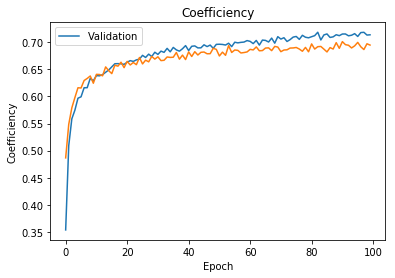

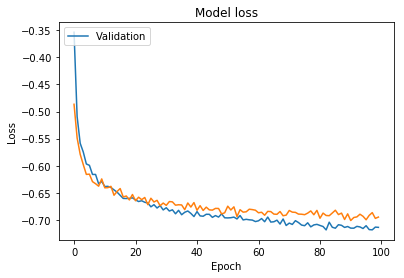

Training co-effiency    : 0.7184177907064433;
Validation co-effiency : 0.6917850740590886


In [6]:
# Plot Training curve
plotTrainigGraph(history.history)

data/train/images/ISIC_0000000.jpg -- jaccard index: 0.7729514837265015
(224, 224, 1)


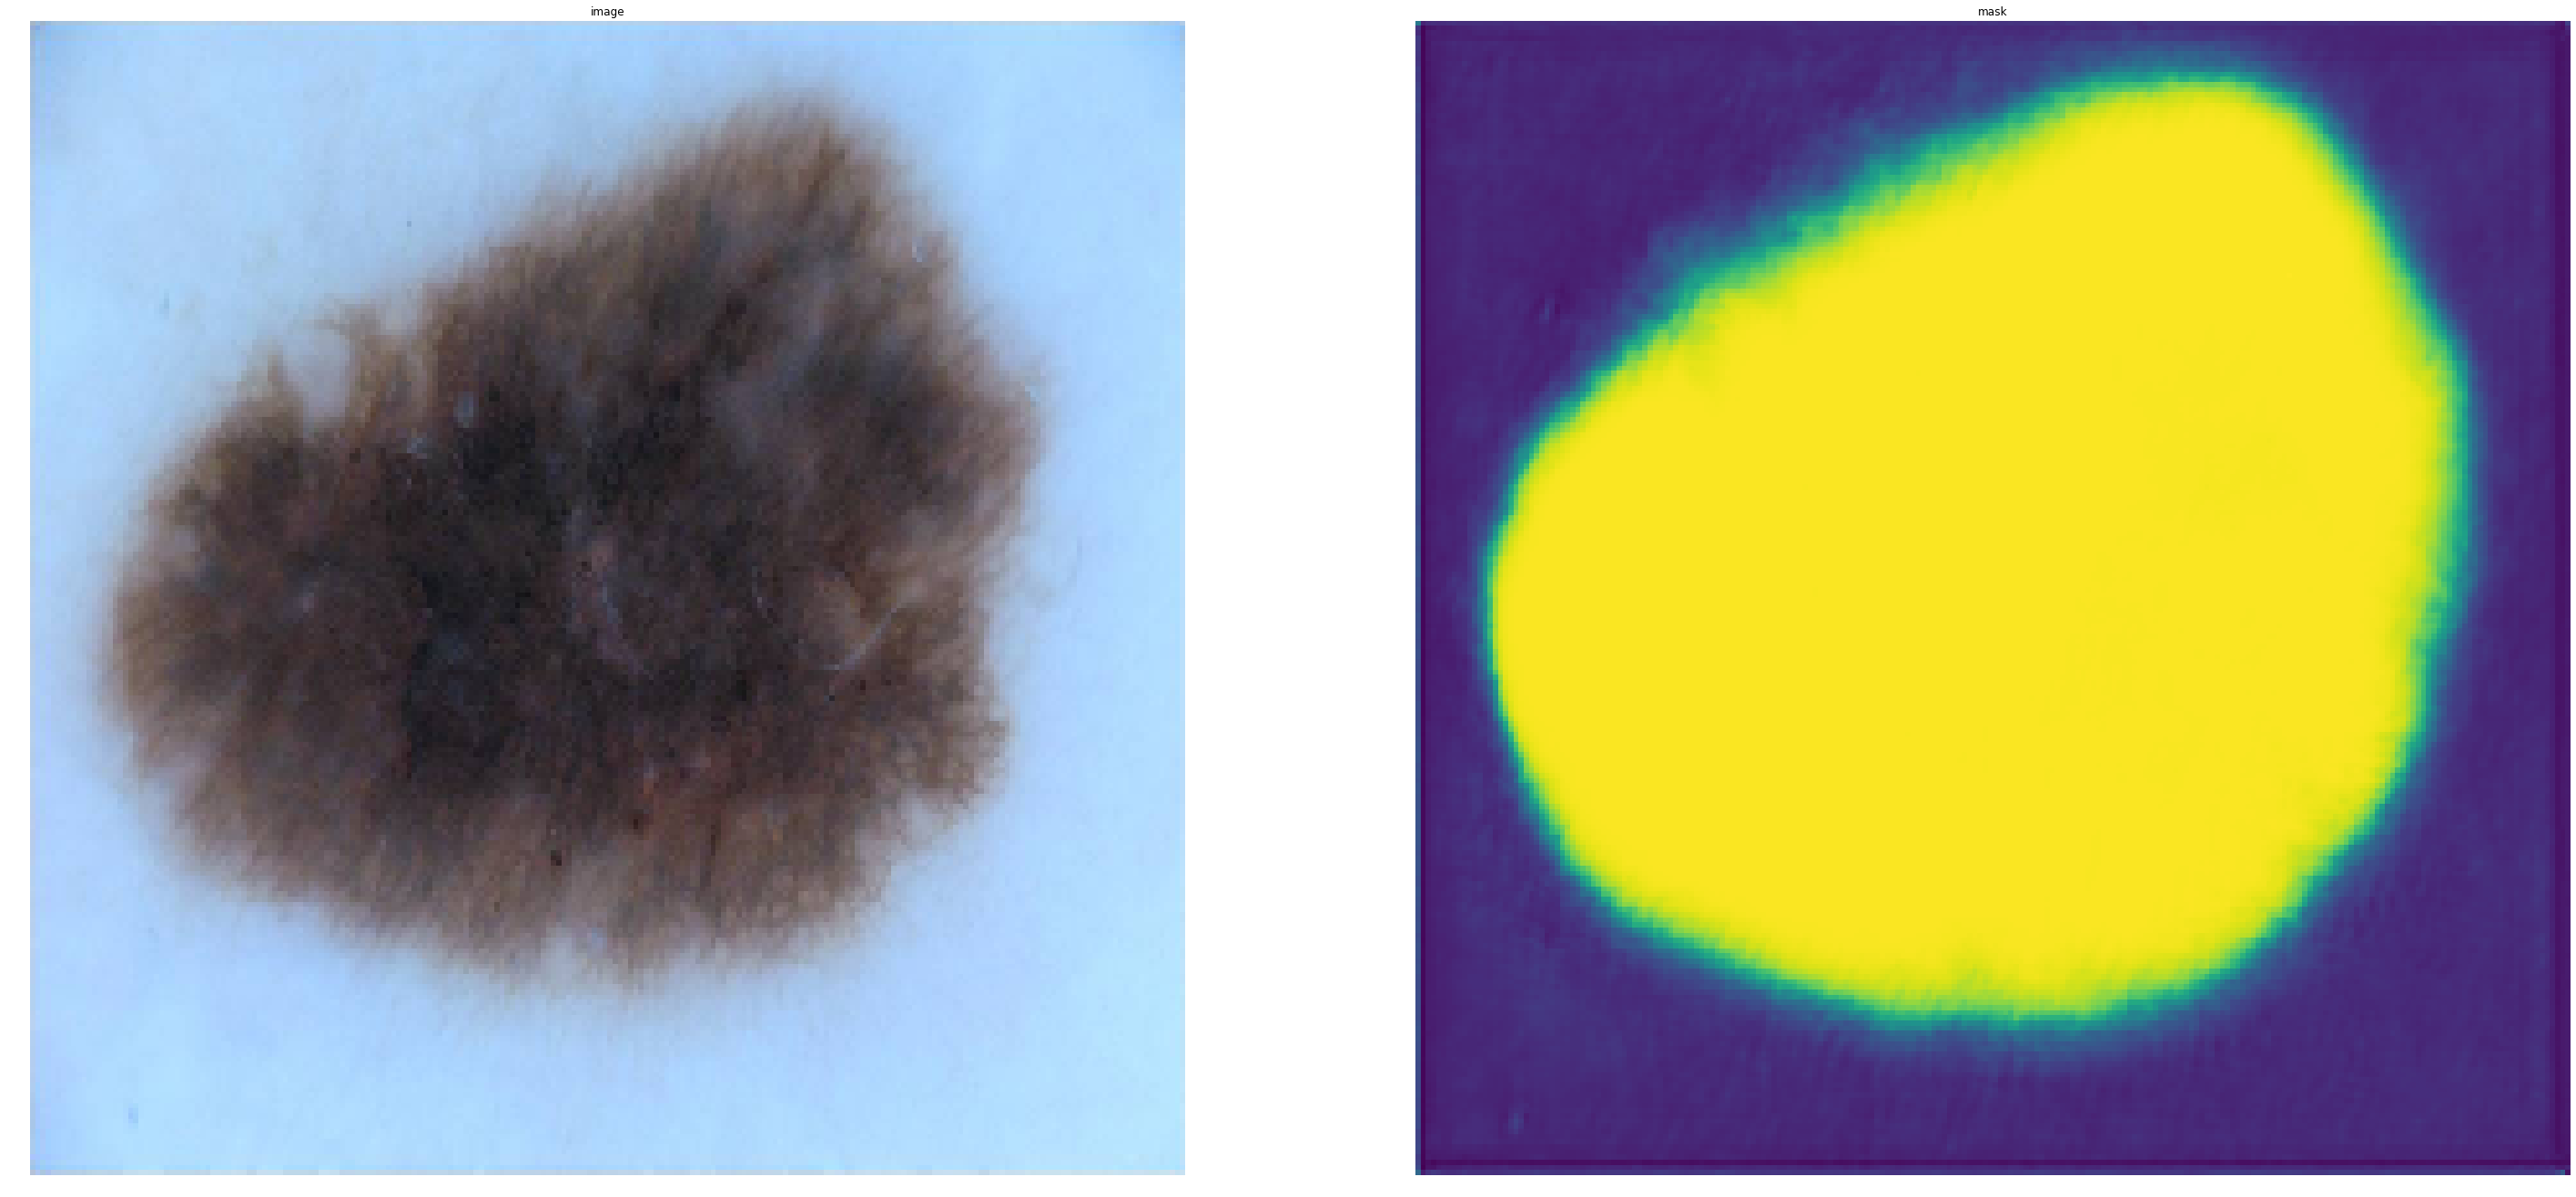

In [42]:
file = 'data/train/images/ISIC_0000000.jpg'
#grey_img = load_img(os.path.join(test_data_dir,file), target_size=(img_rows, img_cols), grayscale=False)
#mask_img = load_img(os.path.join(test_data_mask_dir,file.split('.')[0]+"_segmentation.png"), target_size=(224, 224), grayscale=True)
grey_img = load_img(file, target_size=(224, 224), grayscale=False)
mask_img = load_img('data/train/masks/ISIC_0000000_segmentation.png', target_size=(224, 224), grayscale=True)

img = img_to_array(grey_img)
img_mask = img_to_array(mask_img)

img, img_mask = normalizeData(img, img_mask)
img = np.reshape(img,(1,)+img.shape)

pred = model.predict([img])
sess = tf.Session()
score = sess.run(jaccard_coef(img_mask, pred))
print("{} -- jaccard index: {}".format(file,score))

result_img = array_to_img(pred[0] * 255 )
print(pred[0].shape)
f, ax = plt.subplots(1,2, figsize = (50,50))
ax[0].imshow(grey_img) 
ax[0].axis('off')
ax[0].set_title('image')
ax[1].imshow(result_img)
ax[1].axis('off')
ax[1].set_title('mask')
plt.show()
    

In [ ]:
coef = np.array(hist.history['jaccard_coef'])
val_coef = np.array(hist.history['val_jaccard_coef'])
print("Training co-effiency    : {};\nValidation co-effiency : {}".format(coef[coef==max(coef)][0], val_coef[np.argmax(coef)]))



In [ ]:
# Generate Jaccard Index using test set
predictTestSet("unet/20190519/unet_lesion_20190519_059-0.80857.hdf5")

In [ ]:
#This code combined 2 seperate training history together and plot the result
hist = {}
for i in history.history.keys():
    hist_concate = np.array([np.array(history.history[i]), np.array(history2.history[i])]).flatten() 
    hist[i] = hist_concate

plotTrainigGraph(hist)